In [1]:
import pandas as pd
import numpy as np
import os
os.chdir('../../../../')
print(os.getcwd())
from v2.strategy.indicators.optimal_v2 import Optimal_v2
from v2.model import Trading
from v2.strategy.indicators.param import Param
from v2.strategy.indicators.notebook_utils import fetchIndicators, genDataForAll
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier

/mnt/c/Users/jam60/OneDrive/Repos/vivaldi/back_testing


In [29]:
def load_config():
    my_config = {}
    with open('config.config') as config:
        for line in config:
            args = line.split('=')
            my_config[args[0]] = args[1].rstrip().split(',')
    return my_config

model = Trading(load_config())
my_datasets = [x[0] for x in model.dfs]
dataset = pd.concat(my_datasets)

In [30]:
dataset

,time,open,high,low,close,volume,trades
0,1381095300,123.61000,123.61000,123.61000,123.61000,0.100000,1
1,1381095360,123.91000,123.91000,123.91000,123.91000,1.000000,1
2,1381095420,123.90000,123.90000,123.90000,123.90000,0.991600,1
3,1381095480,124.19000,124.19000,124.19000,124.19000,1.000000,1
4,1381095540,124.18000,124.18000,124.18000,124.18000,1.000000,1
5,1381095600,124.01687,124.01687,124.01687,124.01687,1.000000,1
6,1381095660,124.01687,124.01687,124.01687,124.01687,1.000000,1
7,1381095720,123.84000,123.84000,123.84000,123.84000,0.823000,1
8,1381095780,125.85000,125.85000,125.85000,125.85000,1.000000,1
9,1381095840,125.86000,125.86000,125.86000,125.86000,1.000000,1


In [31]:
my_inds = fetchIndicators(["rsi", "macd", "stochastic_oscillator", "optimal_v2", 'slope', 'variance', 'bollinger_bands', 'smma'])
genDataForAll(dataset, my_inds)
dataset.dropna(inplace=True)

In [4]:
mm_scalar = MinMaxScaler()
dataset[["rsi", "stosc_k", "stosc_d"]] = mm_scalar.fit_transform(dataset[["rsi", "stosc_k", "stosc_d"]])

def filter_optimal(optimal):
    if optimal > 0.9:
        return 1.0
    elif optimal < -0.9:
        return -1.0
    else:
        return 0.0

dataset['optimal'] = dataset.apply(lambda x: filter_optimal(x.optimal), axis=1)

In [5]:
len(dataset[dataset['optimal'] != 0.0])

81063

In [6]:
len(dataset)

3511309

In [7]:


train, test = train_test_split(dataset, test_size=0.2, shuffle=False)


<h3>Models</h3>
<p>Random Forest</p>
<p>Fine tuned RF</p>
<p>Gradient boost</p>
<p>GB inside RF</p>
<p>RF inside GB</p>
<p>LSTM</p>

In [8]:

sell_signals = train[train['optimal'] == -1.0]

In [9]:
mean_num_singals = int(len(sell_signals))

In [10]:
not_signals = train[train['optimal'] == 0.0]


In [11]:
print(mean_num_singals, len(not_signals))

33509 2741387


In [12]:
not_signals_sampled = not_signals.sample(n=mean_num_singals * 4, random_state=69420, axis=0)

In [13]:

balanced_data_sell = pd.concat([not_signals_sampled, sell_signals])

In [14]:
filtered_balanced_data_sell = balanced_data_sell[["close", "rsi", "MACD", "stosc_k", "stosc_d", "slope", "variance"]]



balanced_data_optimal_sell = balanced_data_sell[['optimal']]



In [15]:

clf_sell = RandomForestClassifier(random_state=69420, n_jobs=-1, n_estimators=10)

clf_sell.fit(filtered_balanced_data_sell, balanced_data_optimal_sell)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=69420, verbose=0,
                       warm_start=False)

In [16]:


def insert_sells(close, prediction):
    if prediction == -1:
        return close
    else:
        return None

In [17]:
filtered_test = test[["close", "rsi", "MACD", "stosc_k", "stosc_d", "slope", "variance"]]

In [18]:
filtered_test['predict_sell'] = clf_sell.predict(filtered_test.values)

In [19]:
len(filtered_test)

702262

In [20]:
len(filtered_test[filtered_test['predict_sell'] != 0.0])

73491

In [21]:

filtered_test['sell'] = filtered_test.apply(lambda x: insert_sells(x.close, x.predict_sell), axis=1)

In [22]:
first_amnt = filtered_test.head(11000)

<Figure size 432x288 with 0 Axes>

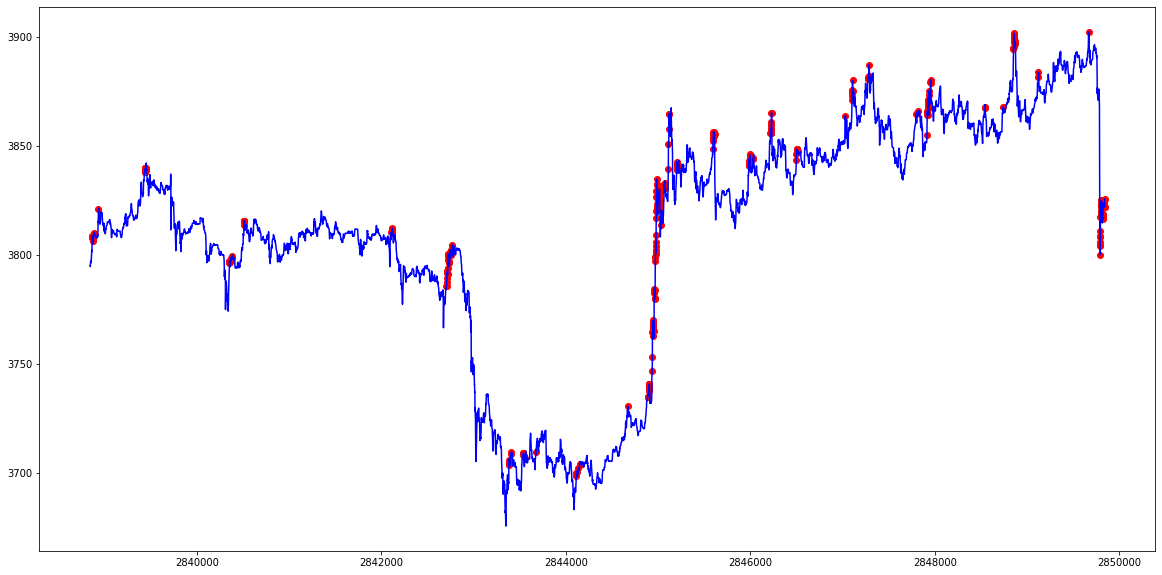

In [23]:
import matplotlib.pyplot as plt
plt.clf()
plt.figure(figsize=(20,10))
plt.scatter(x=first_amnt.index, y=first_amnt['sell'], color='red')

plt.plot(first_amnt.index, first_amnt['close'], color='blue')
plt.show()